### Bot Detection using Digital DNA Compression

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
import sys
import time
import zlib

In [4]:
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

In [5]:
import warnings
warnings.filterwarnings('once')

In [6]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

<hr>

### Digital DNA

Model account behaviour by defining the following alphabet, of cardinality N = 3,

$B^3_{type} = {\{A, C, T\}}$

A $\leftarrow$ tweet,

C $\leftarrow$ reply,

T $\leftarrow$ retweet

<hr>

#### Datasets

User profile data.

In [7]:
### Users

# Genuine accounts.
gen = pd.read_csv('./datasets_full/datasets_full.csv/genuine_accounts.csv/users.csv')

# Social spambots.
ss1 = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_1.csv/users.csv')
ss2 = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_2.csv/users.csv')
ss3 = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_3.csv/users.csv')

# Traditional spambots.
# ts1 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_1.csv/users.csv')
# ts2 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_2.csv/users.csv')
# ts3 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_3.csv/users.csv')
# ts4 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_4.csv/users.csv')

Tweets.

In [8]:
### Tweets

# Genuine accounts.
gen_tweets = pd.read_csv('./datasets_full/datasets_full.csv/genuine_accounts.csv/tweets.csv')

# Social spambots.
ss1_tweets = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_1.csv/tweets.csv')
ss2_tweets = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_2.csv/tweets.csv')
ss3_tweets = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_3.csv/tweets.csv')

# Traditional spambots.
# ts1_tweets = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_1.csv/tweets.csv')

/Users/nivranshu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/nivranshu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/nivranshu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<hr>

#### Digital DNA.

In [9]:
def create_dna_from_tweets(tweets_df):
    '''For each user id in tweets_df return a digital DNA string based on posting behaviour.'''
    
    # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    tweets_df.loc[:, 'DNA'] = np.where(retweets, 'C', np.where(replies, 'T', 'A'))

    # Sort tweets by timestamp.
    tweets_df = tweets_df[['user_id', 'timestamp', 'DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])

    # Create digital DNA string for account.
    dna = tweets_df.groupby(by=['user_id'])['DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [10]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'dna': dna,
                           'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

<hr>

#### Test Set #1

In [11]:
# Genuine accounts in test set 1.
gen_test1 = gen[gen['test_set_1'] == 1]

# Social spambots in test set 1.
ss1_test_1 = ss1[ss1['test_set_1'] == 1]


# Tweets for genuine accounts in test set 1.
gen_tweets_test1 = gen_tweets[gen_tweets['user_id'].isin(gen_test1['id'])]

# Tweets for spambot accounts in test set 1.
ss1_tweets_test1 = ss1_tweets[ss1_tweets['user_id'].isin(ss1_test_1['id'])]


# DNA for genuine accounts in test set 1.
gen_dna_test1 = create_dna_from_tweets(gen_tweets_test1)

# DNA for spambots in test set 1.
ss1_dna_test1 = create_dna_from_tweets(ss1_tweets_test1)


# DNA string compression for genuine accounts in test set 1.
gen_dna_test1 = compress_dna_df(gen_dna_test1)

# DNA string compression for spambots in test set 1.
ss1_dna_test1 = compress_dna_df(ss1_dna_test1)


# Add a column for label to the dataframes.
gen_dna_test1['label'] = 0
ss1_dna_test1['label'] = 1


# Combine test set 1 accounts into a single dataframe.
# dna_test1 = pd.concat([gen_dna_test1, ss1_dna_test1])

/Users/nivranshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/nivranshu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [12]:
np.random.seed(2601)

results_with_length_1 = []
results_with_ratio_1 = []

num_bots = list(range(1, 21))
num_humans = 100

for _ in range(100):
    for n in num_bots:
        bot_dna_test = ss1_dna_test1.sample(2*n)
        gen_dna_test = gen_dna_test1.sample(2*num_humans)
        
        ##### original dna size + compressed dna size
        X_train = pd.concat([gen_dna_test[['original_dna_size', 'compressed_dna_size']].head(num_humans),
                             bot_dna_test[['original_dna_size', 'compressed_dna_size']].head(n)])
        X_test = pd.concat([gen_dna_test[['original_dna_size', 'compressed_dna_size']].tail(num_humans),
                            bot_dna_test[['original_dna_size', 'compressed_dna_size']].tail(n)])

        y_train = pd.concat([gen_dna_test.loc[:, 'label'].head(num_humans), 
                             bot_dna_test.loc[:, 'label'].head(n)])
        y_test = pd.concat([gen_dna_test.loc[:, 'label'].tail(num_humans), 
                             bot_dna_test.loc[:, 'label'].tail(n)])

        # Logistic Regression classifier with default parameters.
        classifier = LogisticRegression()

        # Train the classifier.
        classifier.fit(X_train, y_train)

        # Make predictions on the test set.
        predictions = classifier.predict(X_test)

        # Evaluation on the test set.
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        specificity = tn / (tn+fp)
        
        res = dict()
        res['Accuracy'] = accuracy_score(y_test, predictions)
        res['Precision'] = precision_score(y_test, predictions)
        res['Recall'] = recall_score(y_test, predictions)
        res['F1 Score'] = f1_score(y_test, predictions)
        res['Specificity'] = specificity
        res['MCC'] = matthews_corrcoef(y_test, predictions)
        res['Proportion'] = n / num_humans

        results_with_length_1.append(res.copy())

        
        ##### original dna size + compression ratio
        X_train = pd.concat([gen_dna_test[['original_dna_size', 'compression_ratio']].head(num_humans),
                             bot_dna_test[['original_dna_size', 'compression_ratio']].head(n)])
        X_test = pd.concat([gen_dna_test[['original_dna_size', 'compression_ratio']].tail(num_humans),
                            bot_dna_test[['original_dna_size', 'compression_ratio']].tail(n)])

        y_train = pd.concat([gen_dna_test.loc[:, 'label'].head(num_humans), 
                             bot_dna_test.loc[:, 'label'].head(n)])
        y_test = pd.concat([gen_dna_test.loc[:, 'label'].tail(num_humans), 
                             bot_dna_test.loc[:, 'label'].tail(n)])

        # Logistic Regression classifier with default parameters.
        classifier = LogisticRegression()

        # Train the classifier.
        classifier.fit(X_train, y_train)

        # Make predictions on the test set.
        predictions = classifier.predict(X_test)

        # Evaluation on the test set.
        
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        specificity = tn / (tn+fp)
        
        res = dict()
        res['Accuracy'] = accuracy_score(y_test, predictions)
        res['Precision'] = precision_score(y_test, predictions)
        res['Recall'] = recall_score(y_test, predictions)
        res['F1 Score'] = f1_score(y_test, predictions)
        res['Specificity'] = specificity
        res['MCC'] = matthews_corrcoef(y_test, predictions)
        res['Proportion'] = n / num_humans

        results_with_ratio_1.append(res.copy())
        

results_with_length_1 = pd.DataFrame(results_with_length_1)
results_with_length_1 = results_with_length_1.groupby(['Proportion']).mean().reset_index()

results_with_ratio_1 = pd.DataFrame(results_with_ratio_1)
results_with_ratio_1 = results_with_ratio_1.groupby(['Proportion']).mean().reset_index()

/Users/nivranshu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nivranshu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nivranshu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [13]:
results_with_length_1

,Proportion,Accuracy,F1 Score,MCC,Precision,Recall,Specificity
0,0.01,0.989208,0.457333,0.481017,0.376667,0.650000,0.9926
1,0.02,0.987255,0.599095,0.611712,0.583833,0.680000,0.9934
2,0.03,0.987573,0.762738,0.777051,0.800952,0.803333,0.9931
3,0.04,0.986923,0.831200,0.839246,0.841016,0.877500,0.9913
4,0.05,0.986667,0.854915,0.856598,0.872556,0.868000,0.9926
5,0.06,0.984717,0.851621,0.853577,0.857228,0.880000,0.9910
6,0.07,0.985234,0.889839,0.887526,0.884890,0.914286,0.9902
7,0.08,0.985093,0.894896,0.892143,0.892017,0.915000,0.9907
8,0.09,0.984037,0.906946,0.902061,0.894365,0.932222,0.9887
9,0.10,0.985636,0.922402,0.917992,0.916309,0.940000,0.9902


In [14]:
results_with_ratio_1

,Proportion,Accuracy,F1 Score,MCC,Precision,Recall,Specificity
0,0.01,0.994455,0.610000,0.614038,0.592000,0.650000,0.9979
1,0.02,0.992745,0.787667,0.798370,0.840000,0.790000,0.9968
2,0.03,0.989320,0.805526,0.813652,0.845869,0.816667,0.9945
3,0.04,0.987981,0.843201,0.846744,0.865881,0.857500,0.9932
4,0.05,0.985619,0.839490,0.841978,0.888718,0.828000,0.9935
5,0.06,0.984340,0.864847,0.862339,0.868677,0.881667,0.9905
6,0.07,0.982710,0.864217,0.860565,0.894090,0.854286,0.9917
7,0.08,0.981852,0.875550,0.870240,0.892742,0.873750,0.9905
8,0.09,0.979450,0.872097,0.865159,0.898486,0.860000,0.9902
9,0.10,0.980909,0.889872,0.883635,0.927900,0.866000,0.9924


<hr>

#### Test Set #2

In [15]:
# Genuine accounts in test set 2.
gen_test2 = gen[gen['test_set_2'] == 1]

# Social spambots in test set 2.
ss3_test_2 = ss3[ss3['test_set_2'] == 1]


# Tweets for genuine accounts in test set 2.
gen_tweets_test2 = gen_tweets[gen_tweets['user_id'].isin(gen_test2['id'])]

# Tweets for spambot accounts in test set 2.
ss3_tweets_test2 = ss3_tweets[ss3_tweets['user_id'].isin(ss3_test_2['id'])]


# DNA for genuine accounts in test set 2.
gen_dna_test2 = create_dna_from_tweets(gen_tweets_test2)

# DNA for spambots in test set 2.
ss3_dna_test2 = create_dna_from_tweets(ss3_tweets_test2)


# DNA string compression for genuine accounts in test set 2.
gen_dna_test2 = compress_dna_df(gen_dna_test2)

# DNA string compression for spambots in test set 2.
ss3_dna_test2 = compress_dna_df(ss3_dna_test2)


# Add a column for label to the dataframes.
gen_dna_test2['label'] = 0
ss3_dna_test2['label'] = 1

/Users/nivranshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/nivranshu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [16]:
np.random.seed(2601)

results_with_length_2 = []
results_with_ratio_2 = []

num_bots = list(range(1, 11))
num_humans = 50

for _ in range(100):
    for n in num_bots:
        bot_dna_test = ss3_dna_test2.sample(2*n)
        gen_dna_test = gen_dna_test2.sample(2*num_humans)
        
        ##### original dna size + compressed dna size
        X_train = pd.concat([gen_dna_test[['original_dna_size', 'compressed_dna_size']].head(num_humans),
                             bot_dna_test[['original_dna_size', 'compressed_dna_size']].head(n)])
        X_test = pd.concat([gen_dna_test[['original_dna_size', 'compressed_dna_size']].tail(num_humans),
                            bot_dna_test[['original_dna_size', 'compressed_dna_size']].tail(n)])

        y_train = pd.concat([gen_dna_test.loc[:, 'label'].head(num_humans), 
                             bot_dna_test.loc[:, 'label'].head(n)])
        y_test = pd.concat([gen_dna_test.loc[:, 'label'].tail(num_humans), 
                             bot_dna_test.loc[:, 'label'].tail(n)])

        # Logistic Regression classifier with default parameters.
        classifier = LogisticRegression()

        # Train the classifier.
        classifier.fit(X_train, y_train)

        # Make predictions on the test set.
        predictions = classifier.predict(X_test)

        # Evaluation on the test set.
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        specificity = tn / (tn+fp)
        
        res = dict()
        res['Accuracy'] = accuracy_score(y_test, predictions)
        res['Precision'] = precision_score(y_test, predictions)
        res['Recall'] = recall_score(y_test, predictions)
        res['F1 Score'] = f1_score(y_test, predictions)
        res['Specificity'] = specificity
        res['MCC'] = matthews_corrcoef(y_test, predictions)
        res['Proportion'] = n / num_humans

        results_with_length_2.append(res.copy())

        
        ##### original dna size + compression ratio
        X_train = pd.concat([gen_dna_test[['original_dna_size', 'compression_ratio']].head(num_humans),
                             bot_dna_test[['original_dna_size', 'compression_ratio']].head(n)])
        X_test = pd.concat([gen_dna_test[['original_dna_size', 'compression_ratio']].tail(num_humans),
                            bot_dna_test[['original_dna_size', 'compression_ratio']].tail(n)])

        y_train = pd.concat([gen_dna_test.loc[:, 'label'].head(num_humans), 
                             bot_dna_test.loc[:, 'label'].head(n)])
        y_test = pd.concat([gen_dna_test.loc[:, 'label'].tail(num_humans), 
                             bot_dna_test.loc[:, 'label'].tail(n)])

        # Logistic Regression classifier with default parameters.
        classifier = LogisticRegression()

        # Train the classifier.
        classifier.fit(X_train, y_train)

        # Make predictions on the test set.
        predictions = classifier.predict(X_test)

        # Evaluation on the test set.
        
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        specificity = tn / (tn+fp)
        
        res = dict()
        res['Accuracy'] = accuracy_score(y_test, predictions)
        res['Precision'] = precision_score(y_test, predictions)
        res['Recall'] = recall_score(y_test, predictions)
        res['F1 Score'] = f1_score(y_test, predictions)
        res['Specificity'] = specificity
        res['MCC'] = matthews_corrcoef(y_test, predictions)
        res['Proportion'] = n / num_humans

        results_with_ratio_2.append(res.copy())
        

results_with_length_2 = pd.DataFrame(results_with_length_2)
results_with_length_2 = results_with_length_2.groupby(['Proportion']).mean().reset_index()

results_with_ratio_2 = pd.DataFrame(results_with_ratio_2)
results_with_ratio_2 = results_with_ratio_2.groupby(['Proportion']).mean().reset_index()

/Users/nivranshu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nivranshu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nivranshu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [17]:
results_with_length_2

,Proportion,Accuracy,F1 Score,MCC,Precision,Recall,Specificity
0,0.02,0.996667,0.895000,0.895191,0.893333,0.900000,0.9986
1,0.04,0.995385,0.923667,0.929154,0.971667,0.905000,0.9990
2,0.06,0.992075,0.926310,0.928862,0.966952,0.910000,0.9970
3,0.08,0.990741,0.937416,0.937280,0.958944,0.932500,0.9954
4,0.10,0.990000,0.948302,0.946619,0.961012,0.948000,0.9942
5,0.12,0.987500,0.940952,0.938017,0.964740,0.930000,0.9944
6,0.14,0.986140,0.941694,0.936557,0.966126,0.925714,0.9946
7,0.16,0.984138,0.943228,0.936311,0.950698,0.942500,0.9908
8,0.18,0.980847,0.936979,0.928866,0.950871,0.932222,0.9896
9,0.20,0.982000,0.944985,0.936201,0.960474,0.935000,0.9914


In [18]:
results_with_ratio_2

,Proportion,Accuracy,F1 Score,MCC,Precision,Recall,Specificity
0,0.02,0.995882,0.810000,0.811000,0.805000,0.820000,0.9994
1,0.04,0.992308,0.885048,0.892623,0.942333,0.870000,0.9972
2,0.06,0.991509,0.917310,0.921830,0.964452,0.903333,0.9968
3,0.08,0.990370,0.931437,0.931570,0.958833,0.922500,0.9958
4,0.10,0.988000,0.931003,0.928887,0.956988,0.920000,0.9948
5,0.12,0.985000,0.926844,0.922392,0.959643,0.906667,0.9944
6,0.14,0.981404,0.921829,0.914784,0.950253,0.904286,0.9922
7,0.16,0.984310,0.941297,0.935085,0.968516,0.922500,0.9942
8,0.18,0.982034,0.941714,0.933583,0.949306,0.941111,0.9894
9,0.20,0.978167,0.933532,0.922974,0.955041,0.919000,0.9900


<hr>

In [19]:
results_with_length_1['Feature'] = 'Size of Compressed DNA'
results_with_length_1['Dataset'] = 'Mixed1'
results_with_length_2['Feature'] = 'Size of Compressed DNA'
results_with_length_2['Dataset'] = 'Mixed2'
results_with_ratio_1['Feature'] = 'Compression Ratio'
results_with_ratio_1['Dataset'] = 'Mixed1'
results_with_ratio_2['Feature'] = 'Compression Ratio'
results_with_ratio_2['Dataset'] = 'Mixed2'

results_all = pd.concat([results_with_length_1, results_with_length_2, 
                         results_with_ratio_1, results_with_ratio_2])

<hr>

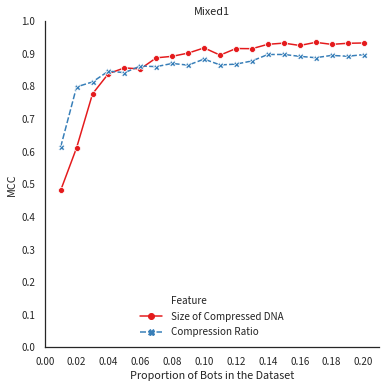

In [20]:
import matplotlib.ticker as mtick

sns.set(style='white', font='Source Sans Pro', palette='Set1', rc={'figure.figsize':(6,6)})

ax = sns.lineplot(x='Proportion', y='MCC', data=results_all[results_all['Dataset'] == 'Mixed1'], 
                  style='Feature', hue='Feature', markers=True)

ax.set_xlim(0., 0.21)
ax.set_ylim(0., 1.0)

ax.xaxis.set_major_locator(mtick.MultipleLocator(0.02))
ax.yaxis.set_major_locator(mtick.MultipleLocator(0.1))

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

ax.set_xlabel('Proportion of Bots in the Dataset')
ax.set_ylabel('MCC')

ax.set_title('Mixed1')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(loc='lower center', frameon=False)

plt.savefig('dna-bot-proportion-mcc-1.pdf')

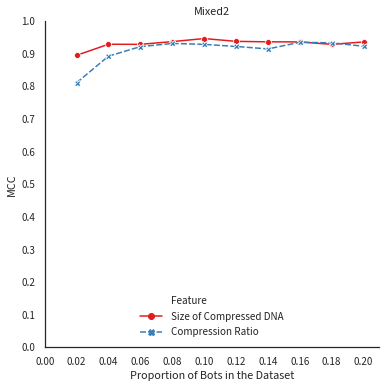

In [21]:
import matplotlib.ticker as mtick

sns.set(style='white', font='Source Sans Pro', palette='Set1', rc={'figure.figsize':(6,6)})

ax = sns.lineplot(x='Proportion', y='MCC', data=results_all[results_all['Dataset'] == 'Mixed2'], 
                  style='Feature', hue='Feature', markers=True)

ax.set_xlim(0., 0.21)
ax.set_ylim(0., 1.0)

ax.xaxis.set_major_locator(mtick.MultipleLocator(0.02))
ax.yaxis.set_major_locator(mtick.MultipleLocator(0.1))

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

ax.set_xlabel('Proportion of Bots in the Dataset')
ax.set_ylabel('MCC')

ax.set_title('Mixed2')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(loc='lower center', frameon=False)

plt.savefig('dna-bot-proportion-mcc-2.pdf')